In [2]:
import cudf
import numpy as np
import pandas as pd
import plotly.express as px
import tools

# init paths to data and models
DATA_PATH = '/data/'

MODEL_NAME = 'wv3_ru'
WORD_MODEL_NAME = 'word_border_wv3_ru'
MODEL_PATH = f'{DATA_PATH}models/{MODEL_NAME}/'
EVENTS_PATH = DATA_PATH + 'events/lem/events.csv'
TMP_PATH = f'{DATA_PATH}tmp/{WORD_MODEL_NAME}/'


'success'

n_clusters = list(range(5, 151))
n_top = list(range(5, 51, 5))

In [3]:
from collections import defaultdict
import math

idf = defaultdict(int)

df = tools.read_events(EVENTS_PATH)

for ind, row in df.iterrows():
    words = set(row['description'].split())
    for word in words:
        idf[word] += 1

doc_len = len(df)
for word in idf:
    idf[word] = math.log(doc_len / idf[word])  

In [4]:
import gensim
model = gensim.models.Word2Vec.load(MODEL_PATH + 'mdl')
wv = model.wv
del model

In [8]:
from collections import Counter


norm = lambda m: m / (((m ** 2).sum(axis=1)) ** (1/2)).reshape(m.shape[0], 1)
rows = []

for ind, document in enumerate(df['description']):
    document = tuple(filter(lambda w: w in wv.vocab, document.split()))
    size = len(document)

    tf = Counter(filter(lambda w: w in wv.vocab, document))
    if len(tf) == 0:
        continue

    words, tf_idf = zip(*((w, tf[w] * idf[w] / size) for w in tf))
    rows.extend(list(zip(words, [ind] * len(words), tf_idf)))
        
df_tf_idf = pd.DataFrame(rows, columns=['word', 'document', 'tf_idf'])

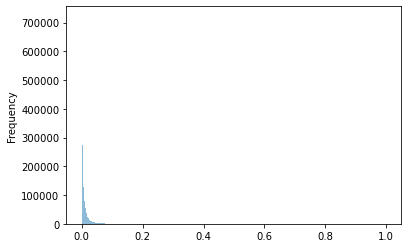

In [20]:
ax = df_tf_idf['tf_idf'][df_tf_idf['tf_idf'] < 1].plot.hist(bins=1000, alpha=0.5)

In [50]:
df_tf_idf['pair'] = list(zip(df_tf_idf['tf_idf'], df_tf_idf['word']))
df_max = df_tf_idf[['document', 'pair']].groupby(by='document').max()
df_max['tf_idf'], df_max['word'] = list(zip(*df_max['pair']))

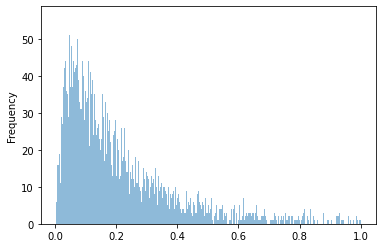

In [56]:
ax = df_max['tf_idf'][df_max['tf_idf'] < 1].plot.hist(bins=1000, alpha=0.5)

In [51]:
df_tf_idf['pair'] = list(zip(df_tf_idf['tf_idf'], df_tf_idf['word']))
df_min = df_tf_idf[['document', 'pair']].groupby(by='document').min()
df_min['tf_idf'], df_min['word'] = list(zip(*df_min['pair']))

10078


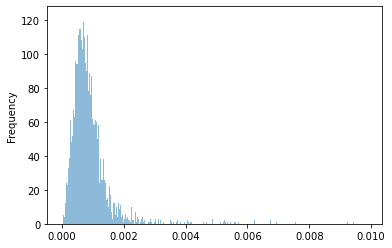

In [63]:
ax = df_min['tf_idf'][df_min['tf_idf'] < 0.01].plot.hist(bins=1000, alpha=0.5)

In [82]:
border = 0.0136
print(len(df_max[df_max['tf_idf'] >= border]))
print(len(df_min[df_min['tf_idf'] < border]))

10084
10084


In [86]:
from itertools import takewhile

is_not_null = []
X = []

for document in df['description']:
    # counting words from document, which have vector in Word Embedding Model
    tf = Counter(filter(lambda w: w in wv.vocab, document.split()))
    # exist small possibility that some document don't contain any word from the WEM   
    if len(tf) == 0:
        is_not_null.append(False)
        continue
    # calculating tf-idf 
    # it isn't necessary to divide tf into len(documents) due to normalizing vectors
    words, tf_idf = zip(*[(w, tf[w] * idf[w]) for w in tf])
    # sorting words of the document by tf_idf and slicing top of them
    score2word = list(takewhile(lambda p: p[0] >= border, sorted(zip(tf_idf, words), reverse=True)))
    # calculating a vector for the document as sum(tf_idf(word) * vec(word)) 
    is_not_null.append(len(score2word) > 0)
    if len(score2word) == 0:
        continue
    vec = sum(map(lambda p: p[0] * wv[p[1]], score2word))
    X.append(vec)
    
X = norm(np.array(X))
df = df[is_not_null]
df = tools.calculate_2d(df, X)

np.save(TMP_PATH + 'X.npy', X)
df.to_csv(r'' + TMP_PATH + 'df.csv', index=False)

/opt/notebooks/tools.py:144: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df_cross = pd.read_csv('cross_valid_union.csv')

df = tools.read_events(TMP_PATH + 'df.csv')
X = np.load(TMP_PATH + 'X.npy')
    
df = tools.k_means_list(n_clusters, df, X)
df_scores = tools.calc_scores_list(n_clusters, df, df_cross)
    
df_scores.to_csv(r'' + TMP_PATH + 'scores_km.csv', index=False)
df.to_csv(r'' + TMP_PATH + 'df_km.csv', index=False)

In [89]:

df_cross = pd.read_csv('cross_valid_union.csv')

df = tools.read_events(TMP_PATH + 'df.csv')
X = np.load(TMP_PATH + 'X.npy')
    
df = tools.agglomerative_list(n_clusters, df, X)
df_scores = tools.calc_scores_list(n_clusters, df, df_cross)
    
df_scores.to_csv(r'' + TMP_PATH + 'scores_ag.csv', index=False)
df.to_csv(r'' + TMP_PATH + 'df_ag.csv', index=False)

In [75]:
df = tools.read_events(TMP_PATH + 'df_ag.csv')
scores = pd.read_csv(TMP_PATH + 'scores_ag.csv')
best = tools.find_best_score(scores, 'f1')
print(best)

tools.plot_score(scores, 'f1').show()

tools.plot_events(df, best['n_clusters']).show()

centroids = tools.calc_centroids(df, best['n_clusters'])

fig, _ = tools.plot_centroids(centroids, size_max=80, size_text_tags=2)
fig.show()

{'name': 'f1', 'value': 0.8679962013295347, 'n_clusters': 12}


In [56]:
df = tools.read_events(TMP_PATH + 'df_ag.csv')
scores = pd.read_csv(TMP_PATH + 'scores_ag.csv')
best = tools.find_best_score(scores, 'f1')
print(best)

tools.plot_score(scores, 'f1').show()

tools.plot_events(df, best['n_clusters']).show()

centroids = tools.calc_centroids(df, best['n_clusters'])

fig, _ = tools.plot_centroids(centroids, size_max=80, size_text_tags=2)
fig.show()

{'name': 'f1', 'value': 0.8612836438923395, 'n_clusters': 20}


In [63]:
df = tools.read_events(TMP_PATH + 'df_ag.csv')
scores = pd.read_csv(TMP_PATH + 'scores_ag.csv')
best = tools.find_best_score(scores, 'f1')
print(best)

tools.plot_score(scores, 'f1').show()

tools.plot_events(df, best['n_clusters']).show()

centroids = tools.calc_centroids(df, best['n_clusters'])

fig, _ = tools.plot_centroids(centroids, size_max=80, size_text_tags=2)
fig.show()

{'name': 'f1', 'value': 0.8147773279352226, 'n_clusters': 20}


In [ ]:
df = tools.read_events(TMP_PATH + 'df_km.csv')
scores = pd.read_csv(TMP_PATH + 'scores_km.csv')
best = tools.find_best_score(scores, 'f1')
print(best)

tools.plot_score(scores, 'f1').show()

tools.plot_events(df, best['n_clusters']).show()

centroids = tools.calc_centroids(df, best['n_clusters'])

fig, _ = tools.plot_centroids(centroids, size_max=80, size_text_tags=2)
fig.show()

In [ ]:
df = tools.read_events(TMP_PATH + 'df.csv')
df_cross = pd.read_csv('cross_valid_union.csv')
X = np.load(TMP_PATH + 'X.npy')

df = tools.k_means_list(n_clusters, df, X)
df_scores = tools.calc_scores_list(n_clusters, df, df_cross)

df.to_csv(r'' + TMP_PATH + 'df_km.csv', index=False)
df_scores.to_csv(r'' + TMP_PATH + 'scores_km.csv', index=False)